## IBGE Data Analysis Project

IBGE is the main source for all kinds os statistical data in Brazil. This repository is an exploration of interesting socioeconomic data as well as concepts like Data visualization, REST API abstraction and Test driven development applied to Data Science.

In [51]:
import urllib3
#import json
import matplotlib.pyplot as plot
import numpy
import pandas
from ibge_lib import *

In [52]:
http = urllib3.PoolManager()
http_fn = lambda url: http.request('GET', url)

aggrs_query_url = aggregates_url()
researches = query_ibge(aggrs_query_url, http_fn)

 ### Picking an aggregate

 IBGE's API needs the exact data aggregate code in order to supply any useful data. Therefore, we need to ask for the list of aggregates and search for the code of the aggregate we want. Luckly, these are grouped by research. In this case, we want the National Household Sampling Research (PNAD).

In [53]:
format_fn = lambda x: f"{x['id']}: {x['nome']}"
researches_fmt = list(map(format_fn, researches))
#researches_fmt

Uncomment the last line in the cell below to see the provided research matadata, including its aggregates.

In [73]:
pnad_id = 'B5'
filter_pnad_fn = lambda x: x['id'] == pnad_id
pnad_metadata = next(filter(filter_pnad_fn, researches)) 
#pnad_metadata

Now, we can use the 'filter_aggregates' function to find researches related to 'household income per capita'.

In [55]:
filtered_aggr = filter_aggregates(pnad_metadata, 'rendimento domiciliar per capita')
format_fn = lambda aggr: f"{aggr['id']}: {aggr['nome']}"
#list(map(format_fn, filtered_aggr))

Then, we store the codes of the aggregates we're interested in the respective variables.

In [56]:
income_bounds_aggr = 7438
cumm_income_dist_aggr = 7530
avg_income_per_class_aggr = 7532

### Income Boundries

This is the household income per capita of the X'th income percentile. For example, if bound(10) = 100, 10% of people earn less than R$ 100 and 90% of people earn more than that.

In [57]:
income_bounds_metadata = query_ibge( metadata_url(income_bounds_aggr), http_fn )
#income_bounds_metadata['variaveis']

In [58]:
income_boounds_var = '10769'
#income_bounds_metadata['classificacoes']

Below is the code to obtain the classification (income percentiles) and classe (the percentiles themselves) and format to a string.

In [74]:
income_bounds_classif = income_bounds_metadata['classificacoes'][0]['id']
income_bounds_classes = [ str(x['id']) for x in income_bounds_metadata['classificacoes'][0]['categorias'] ]
income_bounds_classes_fmt = f'[{",".join(income_bounds_classes)}]'
income_bounds_classes_fmt = f'{income_bounds_classif}{income_bounds_classes_fmt}'
#income_bounds_classes_fmt

'1019[49243,49259,49260,49261,49262,49263,49264,49265,49266,49267,49268,49269,49270]'

Now, we query the IBGE's API with the respective parameters. Note that the response is quite dirty!

In [75]:
var_query_url = variables_url( income_bounds_aggr, [income_boounds_var], [income_bounds_classes_fmt])
income_bounds_response = query_ibge(var_query_url, http_fn )
#income_bounds_response

[{'id': '10769',
  'variavel': 'Limites superiores das classes de percentual das pessoas em ordem crescente de rendimento domiciliar per capita, a preços médios do ano',
  'unidade': 'Reais',
  'resultados': [{'classificacoes': [{'id': '1019',
      'nome': 'Classes de percentual das pessoas em ordem crescente de rendimento domiciliar per capita',
      'categoria': {'49243': 'Total'}}],
    'series': [{'localidade': {'id': '1',
       'nivel': {'id': 'N1', 'nome': 'Brasil'},
       'nome': 'Brasil'},
      'serie': {'2015': '...',
       '2016': '...',
       '2017': '...',
       '2018': '...',
       '2019': '...',
       '2020': '...'}}]},
   {'classificacoes': [{'id': '1019',
      'nome': 'Classes de percentual das pessoas em ordem crescente de rendimento domiciliar per capita',
      'categoria': {'49259': 'P5'}}],
    'series': [{'localidade': {'id': '1',
       'nivel': {'id': 'N1', 'nome': 'Brasil'},
       'nome': 'Brasil'},
      'serie': {'2015': '123',
       '2016': '114

Proceeding extract the results for all classes (income percentiles) followed by the time series for every class.

In [61]:
income_bounds_results = income_bounds_response[0]['resultados'][1:]
income_bounds_serii = map( (lambda x: x['series'][0]['serie']) , income_bounds_results)
income_bounds_serii = list(income_bounds_serii)
#income_bounds_serii

In [62]:
income_percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
income_bound_columns = list(map( (lambda x: f'P{x}'), income_percentiles ))
years_queried = list(map(int, income_bounds_serii[0].keys()))
#years_queried

Now, we create a DataFrame from the time serii.

In [63]:
series_to_row_fn = lambda series: list(map(float, series.values())) # Note: the 'int' refers to the integer constructor
income_bounds_data = list(map( series_to_row_fn , income_bounds_serii ))
income_bounds_data = numpy.matrix(income_bounds_data).transpose()
income_bounds_data = pandas.DataFrame( income_bounds_data , index=years_queried, columns=income_bound_columns )
income_bounds_data

,P5,P10,P20,P30,P40,P50,P60,P70,P80,P90,P95,P99
2015,123.0,198.0,306.0,411.0,529.0,672.0,814.0,1029.0,1380.0,2177.0,3353.0,7758.0
2016,114.0,197.0,307.0,433.0,552.0,696.0,875.0,1082.0,1479.0,2382.0,3714.0,8658.0
2017,102.0,199.0,316.0,451.0,578.0,730.0,933.0,1130.0,1511.0,2453.0,3821.0,9049.0
2018,103.0,201.0,334.0,473.0,610.0,773.0,967.0,1211.0,1641.0,2625.0,4067.0,9893.0
2019,107.0,211.0,348.0,498.0,650.0,826.0,1002.0,1282.0,1733.0,2723.0,4209.0,10365.0
2020,146.0,252.0,396.0,527.0,673.0,836.0,1035.0,1263.0,1682.0,2646.0,4082.0,9832.0


Then, we plot a graph.

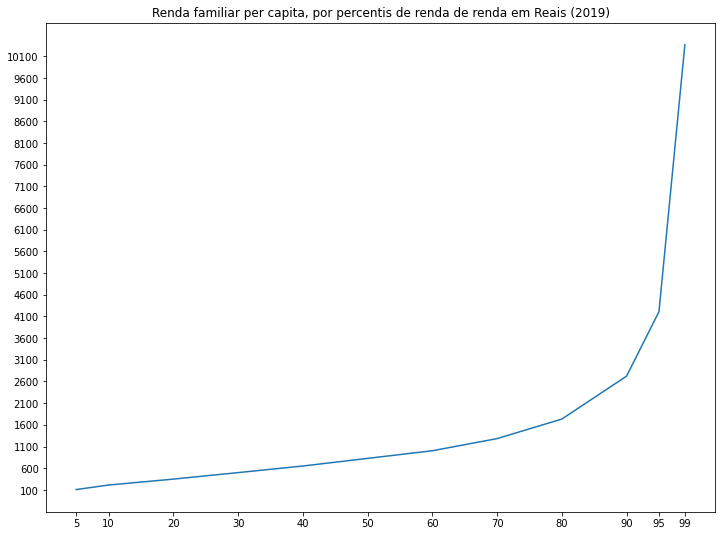

In [64]:
year = 2019
income_boundries = income_bounds_data.loc[[year]].to_numpy()[0]
#income_boundries
fig, ax = plot.subplots()
income_boundries_plot = ax.plot(income_percentiles, income_boundries)
ax.set_title(f'Renda familiar per capita, por percentis de renda de renda em Reais ({year})')

fig.set_size_inches(12, 9)
ax.set_xticks(income_percentiles)
ax.set_yticks(numpy.arange(100, 10101, 500))

income_boundries_plot

### Cumulative Income Distribution

We can do the same for the Cumulative Household Income per Capita Distribution (what a mouthful!).

In [65]:
cumm_income_dist_metadata = query_ibge( metadata_url(cumm_income_dist_aggr), http_fn )
#cumm_income_dist_metadata['variaveis']

In [66]:
cumm_income_dist_var = '10826'
#cumm_income_dist_metadata['classificacoes']

In [67]:
cumm_income_dist_classif = cumm_income_dist_metadata['classificacoes'][0]['id']
cumm_income_dist_classes = cumm_income_dist_metadata['classificacoes'][0]['categorias'][:-1]
cumm_income_dist_classes = map( lambda x: str(x['id']), cumm_income_dist_classes )
cumm_income_dist_classes_fmt = f"{cumm_income_dist_classif}[{','.join(cumm_income_dist_classes)}]"
#list(cumm_income_dist_classes)
#cumm_income_dist_classes_fmt

In [68]:
var_query_url = variables_url( cumm_income_dist_aggr, [cumm_income_dist_var], [cumm_income_dist_classes_fmt])
cumm_income_dist_response = query_ibge(var_query_url, http_fn )

In [69]:
cumm_income_dist_results = cumm_income_dist_response[0]['resultados']
cumm_income_dist_serii = map( lambda x: x['series'][0]['serie'], cumm_income_dist_results )
cumm_income_dist_serii = list(cumm_income_dist_serii)

In [70]:
cumm_income_dist_data = list(map(series_to_row_fn, cumm_income_dist_serii))
cumm_income_dist_data = numpy.matrix(cumm_income_dist_data).transpose()
cumm_income_dist_data = pandas.DataFrame( cumm_income_dist_data , index=years_queried, columns=income_bound_columns )
cumm_income_dist_data

,P5,P10,P20,P30,P40,P50,P60,P70,P80,P90,P95,P99
2015,0.3,1.0,3.4,6.7,11.1,16.6,23.5,32.0,42.9,58.7,71.0,88.7
2016,0.2,0.9,3.1,6.3,10.5,15.8,22.8,30.9,41.8,57.6,70.1,88.4
2017,0.2,0.8,3.0,6.2,10.4,15.7,22.7,30.9,41.8,57.5,69.8,88.3
2018,0.2,0.8,2.9,6.0,10.1,15.4,22.2,30.4,41.2,56.9,69.4,87.8
2019,0.2,0.8,2.9,6.0,10.1,15.5,22.3,30.6,41.5,57.2,69.4,87.6
2020,0.2,0.9,3.4,6.7,11.2,16.8,23.8,32.2,43.0,58.4,70.5,88.2


In [71]:
income_per_class_metadata = query_ibge( metadata_url(avg_income_per_class_aggr), http_fn )

In [72]:
'''
X = income_percentiles
widths = numpy.array([-5,  -5, -10, -10, -10, -10, -10, -10, -10, - 10,  -5,  -4,   -1])
Y = numpy.array(cumm_income_dist_data)

fig, ax = plot.subplots()
ax.bar(X, Y, align='edge', width=widths)
'''

"\nX = income_percentiles\nwidths = numpy.array([-5,  -5, -10, -10, -10, -10, -10, -10, -10, - 10,  -5,  -4,   -1])\nY = numpy.array(cumm_income_dist_data)\n\nfig, ax = plot.subplots()\nax.bar(X, Y, align='edge', width=widths)\n"